In [1]:
import Pkg;
Pkg.activate(@__DIR__)
Pkg.status()

  Activating project at `/global/u1/b/blaschke/juliacon24-hpcworkshop/parts/distributed`


Status `/global/u1/b/blaschke/juliacon24-hpcworkshop/parts/distributed/Project.toml`
  [d58978e5] Dagger v0.18.12
  [aaf54ef3] DistributedArrays v0.6.7
  [91a5bcdd] Plots v1.40.5


In [2]:
using Distributed

addprocs(4)

4-element Vector{Int64}:
 2
 3
 4
 5

In [202]:
@everywhere begin
    D  = 1e-4
    ds = 1e-4
    dt = ds^2 / D / 8.2
    qx(ix, D, C, ds) = -D * (C[ix+1, 1] - C[ix, 1]) / ds
end

In [203]:
dt

1.2195121951219513e-5

In [204]:
@everywhere using DistributedArrays

In [215]:
ras = [@spawnat p zeros(10, 1) for p in workers()]
ras = reshape(ras, (nworkers(), 1))
C   = DArray(ras)

40×1 DArray{Float64, 2, Matrix{Float64}}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [216]:
[@fetchfrom p localindices(C) for p in workers()]

4-element Vector{Tuple{UnitRange{Int64}, UnitRange{Int64}}}:
 (1:10, 1:1)
 (11:20, 1:1)
 (21:30, 1:1)
 (31:40, 1:1)

In [217]:
C[20,1] = 1/ds

LoadError: CanonicalIndexError: setindex! not defined for DArray{Float64, 2, Matrix{Float64}}

In [218]:
target_index = 20
target_value = 1/ds

C = DArray(size(C)) do I
    loc = localpart(C)
    idx = localindices(C)[1] # working in 1D
    
    # If target_index is in the local index, then change the localpart
    if target_index in idx
        loc_i = findfirst(x->x==target_index, idx)
        loc[loc_i] = target_value
    end
    loc
end

40×1 DArray{Float64, 2, Matrix{Float64}}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [219]:
sum(C)*ds

1.0

In [220]:
function step_diffusion(C)
    DArray(size(C)) do I
        loc = localpart(C)
        idx = localindices(C)[1] # working in 1D

        off = idx[1]-1
        for i in idx
            # absorbing boundary conditions (lo, hi are always set to zero)
            if i==1 || i==size(C, 1)
                continue
            end
            il = i - off
            loc[il] = loc[il] - dt * (qx(i, D, C, ds) - qx(i-1, D, C, ds)) / ds
        end

        loc
    end
end

step_diffusion (generic function with 1 method)

In [221]:
sols = [Array(C)]
for i in 1:100
    C = step_diffusion(C)
    # Save timesteps. This is super wasteful, don't do this in production
    if i%10 == 0
        push!(sols, Array(C))
    end
end

In [226]:
using Plots

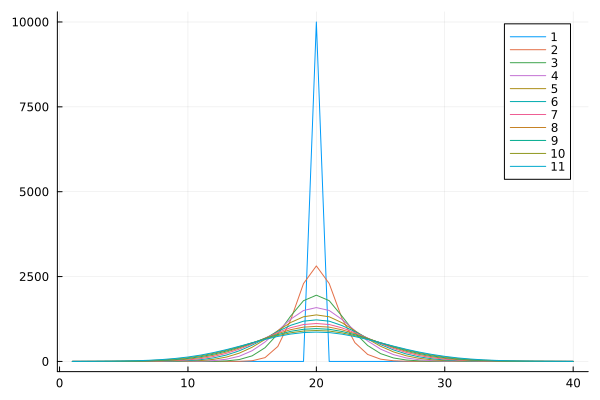

In [227]:
plot()
for (i,c) in enumerate(sols)
    plot!(c, label=i)
end
plot!()

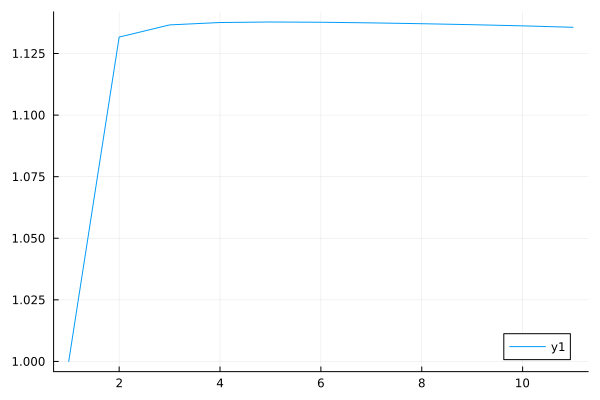

In [228]:
plot([sum(s) for s in sols]*ds)